In [1]:
# Multinomial Naive Bayes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk
import re
import pickle
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import helper.sklearn_to_csv

In [2]:
# COL_OPINION = 0
# COL_SPEECH = 8
#
# RUNS = 1000
# TEST_SPLIT = 0.15
# SHUFFLE = True
# STRATIFY = True
# CLASS_WEIGHTS = True
# REMOVE_STOP_WORDS = False
# STEMMING = False
# LOWERING = False
# NO_PUNCTUATION = False
#
# OUT_NAME = f'measures_mnb_03_{TEST_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
# PATH_METRICS = f'../results/{OUT_NAME}.csv'
# PATH_DATASET = "../protocols/labelled/massnahmen_relevant.csv"
# PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'

In [3]:
COL_OPINION = 6
COL_SPEECH = 13

RUNS = 1000
TEST_SPLIT = 0.15
SHUFFLE = True
STRATIFY = True
CLASS_WEIGHTS = True
REMOVE_STOP_WORDS = False
STEMMING = False
LOWERING = False
NO_PUNCTUATION = False

OUT_NAME = f'lockdown_mnb_03_{TEST_SPLIT}_Shuff{SHUFFLE}_Strat{STRATIFY}_Weigh{CLASS_WEIGHTS}_NoStop{REMOVE_STOP_WORDS}_Stem{STEMMING}_Low{LOWERING}_NoPun{NO_PUNCTUATION}'
PATH_METRICS = f'../results/{OUT_NAME}.csv'
PATH_DATASET = "../protocols/labelled/only_lockdown.csv"
# PATH_PERFORMANCE_GRAPH = f'../results/{OUT_NAME}.png'

In [4]:
# read data from csv
categories = ['-', 'o', '+']
data = pd.read_csv(PATH_DATASET, sep='\t', header=None, skiprows=[0])
data["opinion_integer"] = 0
data.loc[data[COL_OPINION] == '-', "opinion_integer"] = 0
data.loc[data[COL_OPINION] == 'o', "opinion_integer"] = 1
data.loc[data[COL_OPINION] == '+', "opinion_integer"] = 2

nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    if NO_PUNCTUATION:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(text)
    if LOWERING:
        word_tokens = [word.lower() for word in word_tokens]
    else:
        word_tokens = [word for word in word_tokens]

    if REMOVE_STOP_WORDS:
        word_tokens = [word for word in word_tokens if word not in stop_words]

    if STEMMING:
        word_tokens = [stemmer.stem(word) for word in word_tokens]

    return ' '.join(word_tokens)

# Clean Comments
data["comment_clean"] = data.loc[data[COL_SPEECH].str.len() > 1, COL_SPEECH]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)

[nltk_data] Downloading package stopwords to /home/stefan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/stefan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,Das heißt diese Planbarkeit ist jetzt gar nich...,0
1,Wie und wann schaffen wir es aus diesem Lockdo...,0


In [5]:
runs = RUNS
accs = []
for i in range(runs):
    #train_data, test_data, train_label, test_label = corpus_split(20)
    if STRATIFY:
        train_data, test_data, train_label, test_label = train_test_split(data["text"], data["label"], test_size=TEST_SPLIT, shuffle=SHUFFLE, stratify=data["label"])
    else:
        train_data, test_data, train_label, test_label = train_test_split(data["text"], data["label"], test_size=TEST_SPLIT, shuffle=SHUFFLE)

    model = make_pipeline(TfidfVectorizer(), MultinomialNB())

    if CLASS_WEIGHTS:
        train_counts = Counter(train_label)
        num_in_largest_class = max(train_counts.values())
        class_weights = {k: num_in_largest_class / train_counts[k] for k in train_counts.keys()}
        sample_weights = [class_weights[label] for label in train_label]
        model.fit(train_data, train_label, multinomialnb__sample_weight=sample_weights)
    else:
        model.fit(train_data, train_label)

    labels = model.predict(test_data)

    report = metrics.classification_report(test_label, labels, output_dict=True)
    helper.sklearn_to_csv.dict_to_csv(report, PATH_METRICS)

    correct = labels == test_label
    acc = np.array(correct).sum() / len(correct)
    accs.append(acc)
    if i % 100 == 0:
        print(f"Run {i}")

Run 0
Run 100
Run 200
Run 300
Run 400
Run 500
Run 600
Run 700
Run 800
Run 900
Mean Accuracy: 0.4864864864864865


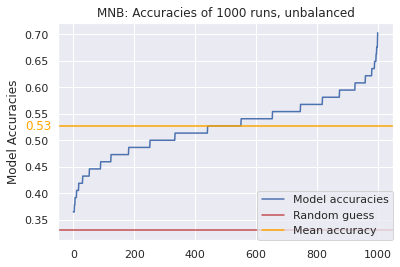

In [6]:
total = len(accs)
mean = sum(accs)/total

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(accs), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=mean, color='orange', linestyle='-', label='Mean accuracy')
ax.text(-0.02, mean, "{:.2f}".format(mean), color='orange', ha="right", va="center",
        transform=ax.get_yaxis_transform())
plt.ylabel('Model Accuracies')
plt.title(f"MNB: Accuracies of {total} runs, unbalanced")
plt.legend(loc="lower right", borderaxespad=0)
# plt.savefig(PATH_PERFORMANCE_GRAPH)
plt.show()

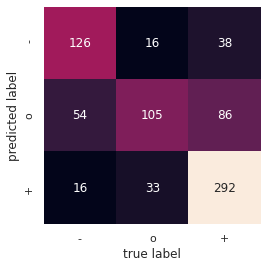

In [6]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_label, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');

